In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import plotly.graph_objects as go
import pickle as pkl
from xgboost import XGBClassifier, plot_importance
import sys
from pathlib import Path
import yfinance as yf
import pandas as pd
from pathlib import Path
from datetime import date, timedelta
pd.set_option('display.max_columns', None)

In [3]:
"""
REPO_ROOT = Path(__file__).resolve().parents[1]
DATA_DIR = REPO_ROOT / "raw_data" / "intraday"
DATA_DIR.mkdir(parents=True, exist_ok=True)

START_DATE = date.today() - timedelta(days=30)
def update_intraday_csv(ticker: str):
    
    #Fetches the most recent 1-minute intraday data for a given ticker,
    #and saves or appends it to 'intraday_{ticker}.csv'.
    
    filepath = DATA_DIR / f"intraday_{ticker}.csv"

    # If file exists, load it; else, create an empty DataFrame
    if filepath.exists():
        old_df = pd.read_csv(filepath, parse_dates=True, index_col='Datetime')
        last_date = old_df.index.max().date() if not old_df.empty else START_DATE
    else:
        old_df = pd.DataFrame()
        last_date = START_DATE

    start_date = last_date + timedelta(days=1)
    end_date = start_date + timedelta(days=8)

    print(f"Fetching {ticker} from {start_date} to {end_date}...")

    df = yf.Ticker(ticker).history(start=start_date, end=end_date, interval="1m")

    if df.empty:
        print(f"No new data returned for {ticker}.")
        if not old_df.empty:
            old_df.to_csv(filepath)
        return

    df.index.name = 'Datetime'

    if old_df.empty:
        df.to_csv(filepath)
    else:
        merged_df = pd.concat([old_df, df], sort=False)
        merged_df = merged_df[~merged_df.index.duplicated(keep='last')]  # drop duplicate indices
        merged_df.to_csv(filepath)

    print(f"Data for {ticker} saved to {filepath.name}.")

"""

'\nREPO_ROOT = Path(__file__).resolve().parents[1]\nDATA_DIR = REPO_ROOT / "raw_data" / "intraday"\nDATA_DIR.mkdir(parents=True, exist_ok=True)\n\nSTART_DATE = date.today() - timedelta(days=30)\ndef update_intraday_csv(ticker: str):\n\n    #Fetches the most recent 1-minute intraday data for a given ticker,\n    #and saves or appends it to \'intraday_{ticker}.csv\'.\n\n    filepath = DATA_DIR / f"intraday_{ticker}.csv"\n\n    # If file exists, load it; else, create an empty DataFrame\n    if filepath.exists():\n        old_df = pd.read_csv(filepath, parse_dates=True, index_col=\'Datetime\')\n        last_date = old_df.index.max().date() if not old_df.empty else START_DATE\n    else:\n        old_df = pd.DataFrame()\n        last_date = START_DATE\n\n    start_date = last_date + timedelta(days=1)\n    end_date = start_date + timedelta(days=8)\n\n    print(f"Fetching {ticker} from {start_date} to {end_date}...")\n\n    df = yf.Ticker(ticker).history(start=start_date, end=end_date, interva

In [4]:
REPO_ROOT = Path.cwd().parents[0]  # going back once from the current directory
SCRIPT_PATH = REPO_ROOT / "scripts"
sys.path.append(str(SCRIPT_PATH))
from intradaydata import update_intraday_csv


update_intraday_csv("NVDA")
update_intraday_csv("INOD")
update_intraday_csv("MRVL")

intraday_nvd = pd.read_csv('..\\raw_data\\intraday\\intraday_NVDA.csv')
intraday_mrvl = pd.read_csv('..\\raw_data\\intraday\\intraday_MRVL.csv')
intraday_inod = pd.read_csv('..\\raw_data\\intraday\\intraday_INOD.csv')

intraday_nvd.head(1)

Fetching NVDA from 2025-07-23 to 2025-07-31...


$NVDA: possibly delisted; no price data found  (1m 2025-07-23 -> 2025-07-31) (Yahoo error = "Data doesn't exist for startDate = 1753243200, endDate = 1753934400")


No new data returned for NVDA.
Fetching INOD from 2025-07-23 to 2025-07-31...


$INOD: possibly delisted; no price data found  (1m 2025-07-23 -> 2025-07-31) (Yahoo error = "Data doesn't exist for startDate = 1753243200, endDate = 1753934400")


No new data returned for INOD.
Fetching MRVL from 2025-07-23 to 2025-07-31...


$MRVL: possibly delisted; no price data found  (1m 2025-07-23 -> 2025-07-31) (Yahoo error = "Data doesn't exist for startDate = 1753243200, endDate = 1753934400")


No new data returned for MRVL.


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-06-23 09:30:00-04:00,143.429993,143.429993,143.429993,143.429993,9728623,0.0,0.0


In [5]:
def cleanup(df):
    """
    Convert 'Datetime' to proper datetime format and extract temporal features.
    Optimizes column types for efficient time-based analysis.
    """
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)

    # Extract temporal components
    df['Date'] = df['Datetime'].dt.date
    df['Time'] = df['Datetime'].dt.time
    df['Hour'] = df['Datetime'].dt.hour
    df['Minute'] = df['Datetime'].dt.minute
    df['Weekday'] = df['Datetime'].dt.day_name()

    # Drop unused or redundant columns
    df = df.drop(columns=['Datetime', 'Dividends', 'Stock Splits'], errors='ignore')

    # Optimize types
    df['Date'] = pd.to_datetime(df['Date'])  # promote from object to datetime64
    df['Weekday'] = pd.Categorical(
        df['Weekday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )

    return df

In [6]:
intraday_nvd = cleanup(intraday_nvd)
intraday_inod = cleanup(intraday_inod)
intraday_mrvl = cleanup(intraday_mrvl)

In [7]:
def feature_selection(df: pd.DataFrame, stock_name: str) -> pd.DataFrame:
    """
    Enhances a stock DataFrame with derived analytical features:
    - Open-Close deltas (absolute and percent)
    - High-Low spreads (absolute and percent from Open/Close)
    - Volume deviation from average (absolute and percent)
    - Stock identifier label
    - Ordered columns
    """
    df = df.copy()  # avoid modifying original

    # Open-Close dynamics
    df['open_close_diff'] = df['Open'] - df['Close']
    df['open_close_diff_pct'] = (df['Close'] - df['Open']) / df['Open']

    # High-Low range
    df['high_low_diff'] = df['High'] - df['Low']
    df['high_low_diff_pct_frm_close'] = df['high_low_diff'] / (df['Close'] + 1e-6)
    df['high_low_diff_pct_frm_close'] = df['high_low_diff'] / df['Close']

    # Volume activity relative to average
    volume_avg = df['Volume'].mean()
    df['volume_diff_frm_avg'] = df['Volume'] - volume_avg
    df['volume_diff_frm_avg_pct'] = df['volume_diff_frm_avg'] / volume_avg

    # Tag the stock
    df['stock'] = stock_name

    # Reorder columns for coherence
    desired_order = [
        'Date',
        'Open', 'Close', 'open_close_diff', 'open_close_diff_pct',
        'High', 'Low', 'high_low_diff', 'high_low_diff_pct_frm_open', 'high_low_diff_pct_frm_close',
        'Volume', 'volume_diff_frm_avg', 'volume_diff_frm_avg_pct',
        'stock'
    ]
    
    # Gracefully reorder only if all desired columns exist
    existing_order = [col for col in desired_order if col in df.columns]
    df = df[existing_order + [col for col in df.columns if col not in existing_order]]
    def prefix_columns(df):
        stock_code = df['stock'].iloc[0] if 'stock' in df.columns else 'Unknown'
        df = df.copy()
        df = df.drop(columns=['stock'])  # remove redundant stock column
        df.columns = [f"{stock_code}_{col}" if col != 'Date' else 'Date' for col in df.columns]
        return df

    df = prefix_columns(df)
    return df

In [8]:
intraday_nvd = feature_selection(intraday_nvd, 'NVDA')
intraday_inod = feature_selection(intraday_inod, 'INOD')
intraday_mrvl = feature_selection(intraday_mrvl, 'MRVL')

In [9]:
def standardize_time_columns(df, ticker):
    return df.rename(columns={
        f'{ticker}_Hour': 'Hour',
        f'{ticker}_Minute': 'Minute',
        f'{ticker}_Time': 'Time',
        f'{ticker}_Weekday': 'Weekday'
    })

# Apply to each DataFrame
intraday_nvd = standardize_time_columns(intraday_nvd, 'NVDA')
intraday_inod = standardize_time_columns(intraday_inod, 'INOD')
intraday_mrvl = standardize_time_columns(intraday_mrvl, 'MRVL')

In [10]:
intraday_combined_df = (
    intraday_nvd
    .merge(intraday_inod, on=['Date', 'Time', 'Hour', 'Minute', 'Weekday'], how='outer')
    .merge(intraday_mrvl, on=['Date', 'Time', 'Hour', 'Minute', 'Weekday'], how='outer')
)

In [11]:
desired_order = [
    'Date', 'Time', 'Hour', 'Minute', 'Weekday',

    # NVDA
    'NVDA_Open', 'NVDA_Close', 'NVDA_open_close_diff', 'NVDA_open_close_diff_pct',
    'NVDA_High', 'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close',
    'NVDA_Volume', 'NVDA_volume_diff_frm_avg', 'NVDA_volume_diff_frm_avg_pct',

    # INOD
    'INOD_Open', 'INOD_Close', 'INOD_open_close_diff', 'INOD_open_close_diff_pct',
    'INOD_High', 'INOD_Low', 'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close',
    'INOD_Volume', 'INOD_volume_diff_frm_avg', 'INOD_volume_diff_frm_avg_pct',

    # MRVL
    'MRVL_Open', 'MRVL_Close', 'MRVL_open_close_diff', 'MRVL_open_close_diff_pct',
    'MRVL_High', 'MRVL_Low', 'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close',
    'MRVL_Volume', 'MRVL_volume_diff_frm_avg', 'MRVL_volume_diff_frm_avg_pct'
]

existing_order = [col for col in desired_order if col in intraday_combined_df.columns]
intraday_combined_df = intraday_combined_df[existing_order + [col for col in intraday_combined_df.columns if col not in existing_order]]

intraday_combined_df.isna().sum()

intraday_combined_df[intraday_combined_df.isna().any(axis=1)]

,Date,Time,Hour,Minute,Weekday,NVDA_Open,NVDA_Close,NVDA_open_close_diff,NVDA_open_close_diff_pct,NVDA_High,NVDA_Low,NVDA_high_low_diff,NVDA_high_low_diff_pct_frm_close,NVDA_Volume,NVDA_volume_diff_frm_avg,NVDA_volume_diff_frm_avg_pct,INOD_Open,INOD_Close,INOD_open_close_diff,INOD_open_close_diff_pct,INOD_High,INOD_Low,INOD_high_low_diff,INOD_high_low_diff_pct_frm_close,INOD_Volume,INOD_volume_diff_frm_avg,INOD_volume_diff_frm_avg_pct,MRVL_Open,MRVL_Close,MRVL_open_close_diff,MRVL_open_close_diff_pct,MRVL_High,MRVL_Low,MRVL_high_low_diff,MRVL_high_low_diff_pct_frm_close,MRVL_Volume,MRVL_volume_diff_frm_avg,MRVL_volume_diff_frm_avg_pct
83,2025-06-23,10:53:00,10,53,Monday,143.729904,143.755005,-0.025101,0.000175,143.759995,143.660004,0.099991,0.000696,182462.0,-239866.855412,-0.567962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.730003,71.709999,0.020004,-0.000279,71.735001,71.669998,0.065002,0.000906,44034.0,-1520.542051,-0.033378
84,2025-06-23,10:54:00,10,54,Monday,143.750107,143.789993,-0.039886,0.000277,143.835007,143.740005,0.095001,0.000661,326498.0,-95830.855412,-0.226911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.650002,71.480103,0.169899,-0.002371,71.650002,71.464996,0.185005,0.002588,62594.0,17039.457949,0.374045
102,2025-06-23,11:17:00,11,17,Monday,144.054993,143.960007,0.094986,-0.000659,144.059998,143.955002,0.104996,0.000729,114500.0,-307828.855412,-0.728884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.400398,71.330002,0.070396,-0.000986,71.400398,71.330002,0.070396,0.000987,4564.0,-40990.542051,-0.899812
103,2025-06-23,11:18:00,11,18,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.930000,47.930000,0.000000,0.000000,47.930000,47.930000,0.000000,0.000000,4707.0,-1457.366099,-0.236418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,2025-06-23,12:54:00,12,54,Monday,143.330002,143.500000,-0.169998,0.001186,143.520004,143.330002,0.190002,0.001324,237125.0,-185203.855412,-0.438530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.404999,70.445000,-0.040001,0.000568,70.470001,70.404999,0.065002,0.000923,14769.0,-30785.542051,-0.675795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243,2025-07-21,10:22:00,10,22,Monday,172.759995,172.690002,0.069992,-0.000405,172.768402,172.649994,0.118408,0.000686,265284.0,-157044.855412,-0.371854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.150002,73.099998,0.050003,-0.000684,73.169998,73.099998,0.070000,0.000958,29862.0,-15692.542051,-0.344478
7439,2025-07-21,13:38:00,13,38,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.869999,46.869999,0.000000,0.000000,46.869999,46.869999,0.000000,0.000000,6354.0,189.633901,0.030763,73.044998,73.040001,0.004997,-0.000068,73.059700,73.035004,0.024696,0.000338,23654.0,-21900.542051,-0.480754
7587,2025-07-22,09:36:00,9,36,Tuesday,168.800003,168.970398,-0.170395,0.001009,169.039993,168.449997,0.589996,0.003492,1415981.0,993652.144588,2.352792,46.900002,46.867100,0.032902,-0.000702,46.978001,46.855000,0.123001,0.002624,3467.0,-2697.366099,-0.437574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7588,2025-07-22,09:37:00,9,37,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.849998,46.820000,0.029999,-0.000640,46.849998,46.820000,0.029999,0.000641,2229.0,-3935.366099,-0.638406,72.870003,72.919998,-0.049995,0.000686,72.919998,72.858704,0.061295,0.000841,91447.0,45892.457949,1.007418


In [12]:
intraday_combined_df.loc[[102,103, 104]]


,Date,Time,Hour,Minute,Weekday,NVDA_Open,NVDA_Close,NVDA_open_close_diff,NVDA_open_close_diff_pct,NVDA_High,NVDA_Low,NVDA_high_low_diff,NVDA_high_low_diff_pct_frm_close,NVDA_Volume,NVDA_volume_diff_frm_avg,NVDA_volume_diff_frm_avg_pct,INOD_Open,INOD_Close,INOD_open_close_diff,INOD_open_close_diff_pct,INOD_High,INOD_Low,INOD_high_low_diff,INOD_high_low_diff_pct_frm_close,INOD_Volume,INOD_volume_diff_frm_avg,INOD_volume_diff_frm_avg_pct,MRVL_Open,MRVL_Close,MRVL_open_close_diff,MRVL_open_close_diff_pct,MRVL_High,MRVL_Low,MRVL_high_low_diff,MRVL_high_low_diff_pct_frm_close,MRVL_Volume,MRVL_volume_diff_frm_avg,MRVL_volume_diff_frm_avg_pct
102,2025-06-23,11:17:00,11,17,Monday,144.054993,143.960007,0.094986,-0.000659,144.059998,143.955002,0.104996,0.000729,114500.0,-307828.855412,-0.728884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.400398,71.330002,0.070396,-0.000986,71.400398,71.330002,0.070396,0.000987,4564.0,-40990.542051,-0.899812
103,2025-06-23,11:18:00,11,18,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.930000,47.930000,0.00,0.000000,47.930000,47.930000,0.00,0.00000,4707.0,-1457.366099,-0.236418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,2025-06-23,11:19:00,11,19,Monday,144.154205,144.205002,-0.050797,0.000352,144.210007,144.149994,0.060013,0.000416,675978.0,253649.144588,0.600596,47.950001,47.860001,0.09,-0.001877,47.950001,47.860001,0.09,0.00188,1144.0,-5020.366099,-0.814417,71.360001,71.379997,-0.019997,0.000280,71.389999,71.360001,0.029999,0.000420,102189.0,56634.457949,1.243223


It is to be decided that across all instances of NaN, these columns will be dropped. Since the 1 minute ticker basis does offer an enough inspection into the granularity of the stocks' behavior.

In [13]:
intraday_combined_df = intraday_combined_df.dropna(axis=0)

#intraday_combined_df.isna().sum()

In [14]:
#Further data preparation steps:
# Classification & Probabilistic Conditioning
intraday_combined_df['INOD_up'] = (intraday_combined_df['INOD_open_close_diff_pct'] > 0).astype(int)
intraday_combined_df['NVDA_up'] = (intraday_combined_df['NVDA_open_close_diff_pct'] > 0).astype(int)
intraday_combined_df['MRVL_up'] = (intraday_combined_df['MRVL_open_close_diff_pct'] > 0).astype(int)

threshold = 50  
intraday_combined_df['NVDA_volume_spike'] = (
    intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] > threshold
).astype(int)

In [15]:
from datetime import time
intraday_combined_df['Time'] = pd.to_datetime(intraday_combined_df['Time'], format='%H:%M:%S').dt.time



def classify_rth_segment(t):
    if time(9, 30) <= t < time(10, 0):
        return 'Opening Bell'
    elif time(10, 0) <= t < time(11, 30):
        return 'Morning Trend'
    elif time(11, 30) <= t < time(14, 0):
        return 'Midday Lull'
    elif time(14, 0) <= t < time(15, 30):
        return 'Afternoon Run'
    elif time(15, 30) <= t < time(16, 0):
        return 'Closing Rush'
    else:
        return None  # Outside RTH
    
intraday_combined_df['rth_segment'] = intraday_combined_df['Time'].apply(classify_rth_segment)

intraday_combined_df.sort_values(by='Time', ascending=False).head()

,Date,Time,Hour,Minute,Weekday,NVDA_Open,NVDA_Close,NVDA_open_close_diff,NVDA_open_close_diff_pct,NVDA_High,NVDA_Low,NVDA_high_low_diff,NVDA_high_low_diff_pct_frm_close,NVDA_Volume,NVDA_volume_diff_frm_avg,NVDA_volume_diff_frm_avg_pct,INOD_Open,INOD_Close,INOD_open_close_diff,INOD_open_close_diff_pct,INOD_High,INOD_Low,INOD_high_low_diff,INOD_high_low_diff_pct_frm_close,INOD_Volume,INOD_volume_diff_frm_avg,INOD_volume_diff_frm_avg_pct,MRVL_Open,MRVL_Close,MRVL_open_close_diff,MRVL_open_close_diff_pct,MRVL_High,MRVL_Low,MRVL_high_low_diff,MRVL_high_low_diff_pct_frm_close,MRVL_Volume,MRVL_volume_diff_frm_avg,MRVL_volume_diff_frm_avg_pct,INOD_up,NVDA_up,MRVL_up,NVDA_volume_spike,rth_segment
1143,2025-06-25,15:59:00,15,59,Wednesday,154.184998,154.309998,-0.125000,0.000811,154.410004,154.169998,0.240005,0.001555,3541492.0,3.119163e+06,7.385626,46.384998,46.369999,0.014999,-0.000323,46.445000,46.340000,0.105000,0.002264,42162.0,35997.633901,5.839633,75.889999,75.940002,-0.050003,0.000659,76.000000,75.870003,0.129997,0.001712,468821.0,423266.457949,9.291422,0,1,1,0,Closing Rush
2700,2025-07-01,15:59:00,15,59,Tuesday,153.449997,153.279999,0.169998,-0.001108,153.485001,153.210007,0.274994,0.001794,2547383.0,2.125054e+06,5.031752,47.450001,47.360001,0.090000,-0.001897,47.470001,47.349998,0.120003,0.002534,36192.0,30027.633901,4.871163,76.360001,76.235001,0.125000,-0.001637,76.389999,76.180000,0.209999,0.002755,470541.0,424986.457949,9.329179,0,0,0,0,Closing Rush
5632,2025-07-14,15:59:00,15,59,Monday,164.154999,164.070007,0.084991,-0.000518,164.160004,164.029999,0.130005,0.000792,1602860.0,1.180531e+06,2.795289,50.410000,50.360001,0.049999,-0.000992,50.430000,50.340000,0.090000,0.001787,41530.0,35365.633901,5.737108,72.529999,72.529999,0.000000,0.000000,72.595001,72.500000,0.095001,0.001310,228210.0,182655.457949,4.009599,0,0,0,0,Closing Rush
4854,2025-07-10,15:59:00,15,59,Thursday,164.104996,164.104996,0.000000,0.000000,164.160004,164.000000,0.160004,0.000975,1649841.0,1.227512e+06,2.906532,52.700001,52.709999,-0.009998,0.000190,52.720001,52.669998,0.050003,0.000949,19015.0,12850.633901,2.084664,73.309998,73.350998,-0.041000,0.000559,73.370003,73.285004,0.084999,0.001159,337660.0,292105.457949,6.412214,1,0,1,0,Closing Rush
4074,2025-07-08,15:59:00,15,59,Tuesday,159.979996,160.000107,-0.020111,0.000126,160.070007,159.934998,0.135010,0.000844,1836744.0,1.414415e+06,3.349085,50.955002,50.970001,-0.014999,0.000294,51.009998,50.950001,0.059998,0.001177,25994.0,19829.633901,3.216816,72.029999,71.930000,0.099998,-0.001388,72.040001,71.919998,0.120003,0.001668,540925.0,495370.457949,10.874228,1,1,0,0,Closing Rush


Simple A/B testing

In [16]:
threshold = intraday_combined_df['NVDA_volume_diff_frm_avg_pct'].median()
group_high = intraday_combined_df[intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] > threshold]['INOD_open_close_diff_pct']
group_low = intraday_combined_df[intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] <= threshold]['INOD_open_close_diff_pct']

from datetime import date

date = pd.to_datetime('2025-07-02')

timeframe_start = pd.to_datetime('2025-07-02')
timeframe_end = timeframe_start + pd.Timedelta(days=5)

d = intraday_combined_df[intraday_combined_df['Date'] == date]

tf = intraday_combined_df[(intraday_combined_df['Date'] >= timeframe_start) & (intraday_combined_df['Date'] <= timeframe_end)]

d_threshold = d['NVDA_volume_diff_frm_avg_pct'].median()
d_group_high = d[d['NVDA_volume_diff_frm_avg_pct'] > threshold]['INOD_open_close_diff_pct']
d_group_low = d[d['NVDA_volume_diff_frm_avg_pct'] <= threshold]['INOD_open_close_diff_pct']

tf_threshold = tf['NVDA_volume_diff_frm_avg_pct'].median()
tf_group_high = tf[tf['NVDA_volume_diff_frm_avg_pct'] > threshold]['INOD_open_close_diff_pct']
tf_group_low = tf[tf['NVDA_volume_diff_frm_avg_pct'] <= threshold]['INOD_open_close_diff_pct']

In [17]:
t_test, p_value = ttest_ind(
    group_high, group_low, equal_var=False)

d_t_test,d_p_value = ttest_ind(
    d_group_high, d_group_low, equal_var=False)

tf_t_test, tf_p_value = ttest_ind(
    tf_group_high, tf_group_low, equal_var=False)

print(f'Mean High: {group_high.mean():.4f}')
print(f'Mean Low: {group_low.mean():.4f}')
print(f'T-test: {t_test:.4f}, P-value: {p_value:.4f}')

print(f'Mean High: {d_group_high.mean():.4f}')
print(f'Mean Low: {d_group_low.mean():.4f}')
print(f'T-test: {d_t_test:.4f}, P-value: {d_p_value:.4f}')

print(f'Mean High: {tf_group_high.mean():.4f}')
print(f'Mean Low: {tf_group_low.mean():.4f}')
print(f'T-test: {tf_t_test:.4f}, P-value: {tf_p_value:.4f}')


Mean High: -0.0000
Mean Low: 0.0000
T-test: -0.7584, P-value: 0.4483
Mean High: 0.0002
Mean Low: 0.0001
T-test: 0.4974, P-value: 0.6194
Mean High: 0.0001
Mean Low: 0.0001
T-test: 0.2678, P-value: 0.7889


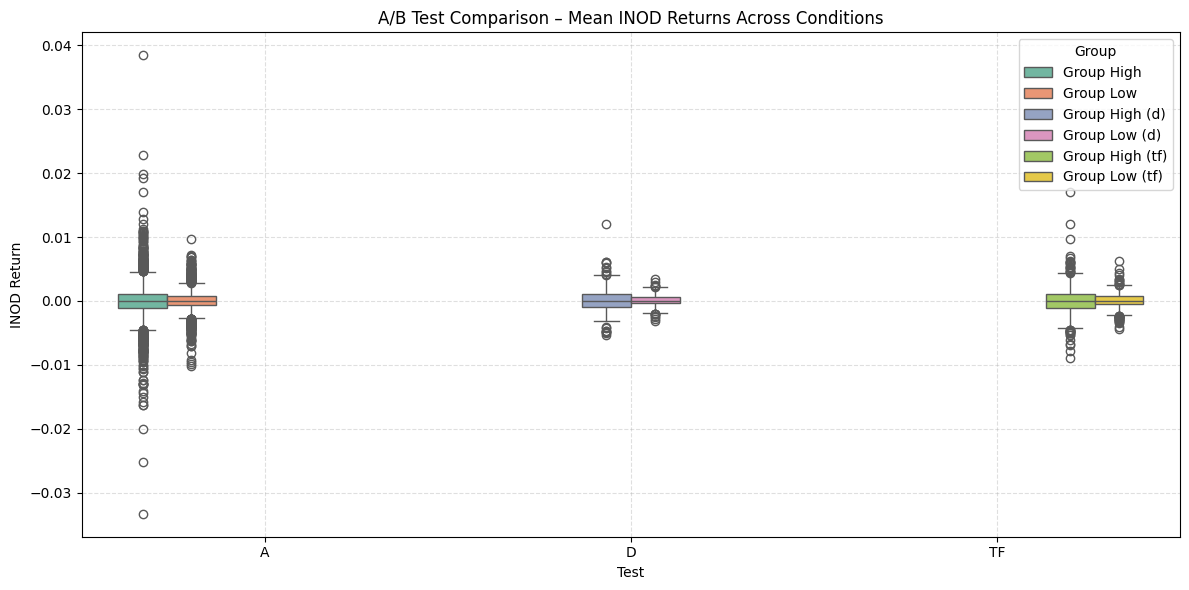

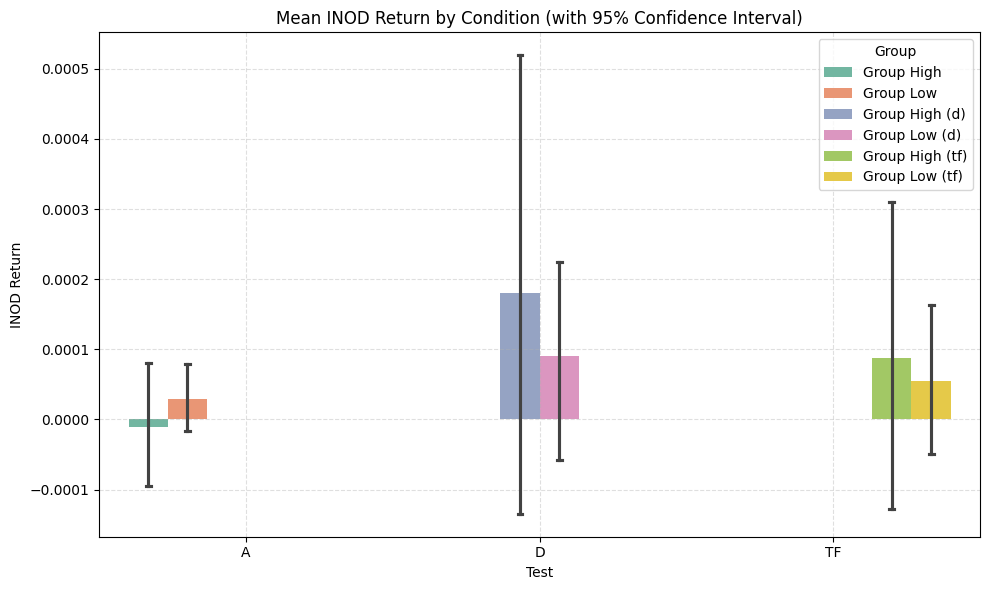

In [18]:
plot_df = pd.DataFrame({
    'INOD Return': group_high.tolist() + group_low.tolist() +
                   d_group_high.tolist() + d_group_low.tolist() +
                   tf_group_high.tolist() + tf_group_low.tolist(),
    'Group': (['Group High'] * len(group_high) + ['Group Low'] * len(group_low) +
              ['Group High (d)'] * len(d_group_high) + ['Group Low (d)'] * len(d_group_low) +
              ['Group High (tf)'] * len(tf_group_high) + ['Group Low (tf)'] * len(tf_group_low)),
    'Test': (['A'] * (len(group_high) + len(group_low)) +
             ['D'] * (len(d_group_high) + len(d_group_low)) +
             ['TF'] * (len(tf_group_high) + len(tf_group_low)))
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Test', y='INOD Return', hue='Group', data=plot_df, palette='Set2')
plt.title('A/B Test Comparison – Mean INOD Returns Across Conditions')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Test', y='INOD Return', hue='Group', data=plot_df, errorbar=('ci', 95), palette='Set2', capsize=0.1)
plt.title('Mean INOD Return by Condition (with 95% Confidence Interval)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

=> We do not accept the notion that INOD changes throughout the day is affected by NVDA's volume.

Simple Regression:


--- Model 1: INOD ~ NVDA_return ---
                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.038
Model:                                  OLS   Adj. R-squared:                  0.038
Method:                       Least Squares   F-statistic:                     295.4
Date:                      Tue, 22 Jul 2025   Prob (F-statistic):           6.07e-65
Time:                              17:50:27   Log-Likelihood:                 34709.
No. Observations:                      7414   AIC:                        -6.941e+04
Df Residuals:                          7412   BIC:                        -6.940e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------

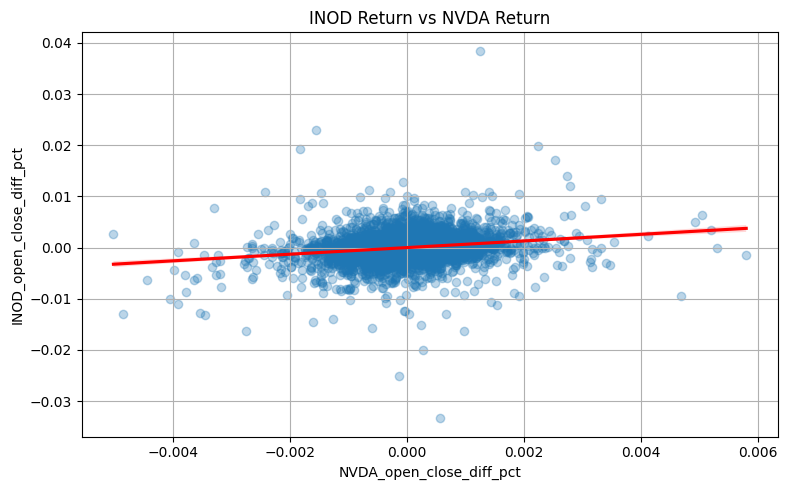

In [19]:
# Regression 1: INOD ~ NVDA return
X1 = sm.add_constant(intraday_combined_df['NVDA_open_close_diff_pct'])
y1 = intraday_combined_df['INOD_open_close_diff_pct']

model1 = sm.OLS(y1, X1).fit()
print("\n--- Model 1: INOD ~ NVDA_return ---")
print(model1.summary())

plt.figure(figsize=(8, 5))
sns.regplot(
    x='NVDA_open_close_diff_pct',
    y='INOD_open_close_diff_pct',
    data=intraday_combined_df,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.3}
)
plt.title('INOD Return vs NVDA Return')
plt.xlabel('NVDA_open_close_diff_pct')
plt.ylabel('INOD_open_close_diff_pct')
plt.grid(True)
plt.tight_layout()
plt.show()



--- Model 2: INOD ~ NVDA_volume_diff ---
                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.004
Model:                                  OLS   Adj. R-squared:                  0.004
Method:                       Least Squares   F-statistic:                     28.34
Date:                      Tue, 22 Jul 2025   Prob (F-statistic):           1.05e-07
Time:                              17:50:27   Log-Likelihood:                 34578.
No. Observations:                      7414   AIC:                        -6.915e+04
Df Residuals:                          7412   BIC:                        -6.914e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------

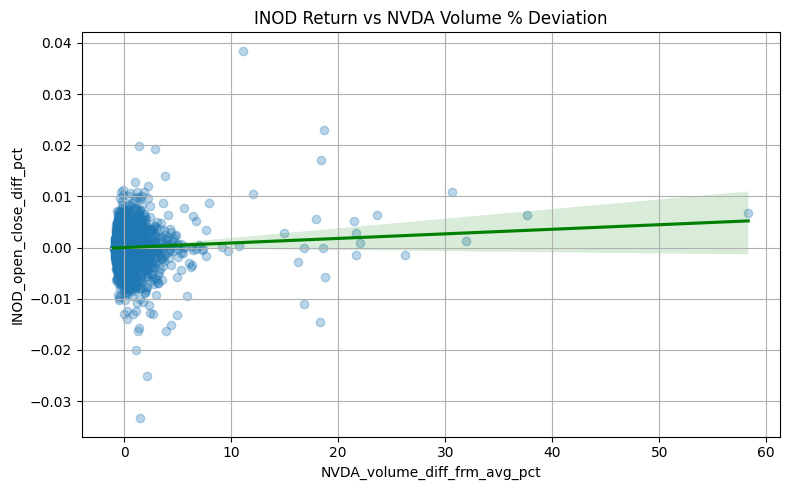

In [20]:
# Regression 2: INOD ~ NVDA volume diff
X2 = sm.add_constant(intraday_combined_df['NVDA_volume_diff_frm_avg_pct'])

model2 = sm.OLS(y1, X2).fit()
print("\n--- Model 2: INOD ~ NVDA_volume_diff ---")
print(model2.summary())
plt.figure(figsize=(8, 5))
sns.regplot(
    x='NVDA_volume_diff_frm_avg_pct',
    y='INOD_open_close_diff_pct',
    data=intraday_combined_df,
    line_kws={"color": "green"},
    scatter_kws={"alpha": 0.3}
)
plt.title('INOD Return vs NVDA Volume % Deviation')
plt.xlabel('NVDA_volume_diff_frm_avg_pct')
plt.ylabel('INOD_open_close_diff_pct')
plt.grid(True)
plt.tight_layout()
plt.show()

Multivariate Regression:

In [21]:
X_multivariate = intraday_combined_df[['NVDA_open_close_diff_pct', 'NVDA_volume_diff_frm_avg_pct']]
X_multivariate = sm.add_constant(X_multivariate)
model_multivariate = sm.OLS(y1, X_multivariate).fit()

print("\n=== Multivariate Regression Results ===")
print(model_multivariate.summary())

adjusted_r_squared = model_multivariate.rsquared_adj
print(f"\nAdjusted R² (Multivariate): {adjusted_r_squared:.6f}")



=== Multivariate Regression Results ===
                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.041
Model:                                  OLS   Adj. R-squared:                  0.041
Method:                       Least Squares   F-statistic:                     157.6
Date:                      Tue, 22 Jul 2025   Prob (F-statistic):           8.94e-68
Time:                              17:50:27   Log-Likelihood:                 34718.
No. Observations:                      7414   AIC:                        -6.943e+04
Df Residuals:                          7411   BIC:                        -6.941e+04
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------

Interaction Term Regression

In [22]:
intraday_combined_df['interaction_NVDA_return_volume'] = (intraday_combined_df['NVDA_open_close_diff_pct'] *
    intraday_combined_df['NVDA_volume_diff_frm_avg'])

X_interaction = intraday_combined_df[[
    'NVDA_open_close_diff_pct',
    'NVDA_volume_diff_frm_avg',
    'interaction_NVDA_return_volume'
]]

X_interaction = sm.add_constant(X_interaction)
model_interaction = sm.OLS(y1, X_interaction).fit()

print("\n=== Interaction Term Regression Results ===")
print(model_interaction.summary())

adjusted_r2_interaction = model_interaction.rsquared_adj
print(f"\nAdjusted R² (Interaction Term Model): {adjusted_r2_interaction:.6f}")


=== Interaction Term Regression Results ===
                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.041
Model:                                  OLS   Adj. R-squared:                  0.041
Method:                       Least Squares   F-statistic:                     106.9
Date:                      Tue, 22 Jul 2025   Prob (F-statistic):           9.99e-68
Time:                              17:50:27   Log-Likelihood:                 34721.
No. Observations:                      7414   AIC:                        -6.943e+04
Df Residuals:                          7410   BIC:                        -6.941e+04
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------

Conditional Probality & Bayes' Theorem:

In [23]:
p_b = intraday_combined_df['NVDA_volume_spike'].sum() / len(intraday_combined_df)

joint_event = ((intraday_combined_df['NVDA_volume_spike'] == 1) & (intraday_combined_df['INOD_up'] == 1)).sum()

p_a_and_b = joint_event/ len(intraday_combined_df)

p_a_given_b = p_a_and_b / p_b

print("P(INOD_up | NVDA_volume_spike):", p_a_given_b)


# Bayesian Probability
p_inod_up = intraday_combined_df['INOD_up'].sum() / len(intraday_combined_df)

p_nvda_spike_given_inod_up = intraday_combined_df[intraday_combined_df['INOD_up'] == 1]['NVDA_volume_spike'].sum() / intraday_combined_df['INOD_up'].sum()

bayes_result = (p_nvda_spike_given_inod_up * p_inod_up) / p_b
print("Bayesian P(INOD_up | NVDA_volume_spike):", bayes_result)

P(INOD_up | NVDA_volume_spike): 1.0
Bayesian P(INOD_up | NVDA_volume_spike): 1.0


In [24]:
"""
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# For demonstration: assuming y_pred_prob already exists
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).astype(int)
y_true = df['INOD_up']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
"""

'\nfrom sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score\n\n# For demonstration: assuming y_pred_prob already exists\nthreshold = 0.5\ny_pred_class = (y_pred_prob >= threshold).astype(int)\ny_true = df[\'INOD_up\']\n\n# Confusion Matrix\ncm = confusion_matrix(y_true, y_pred_class)\nprint("Confusion Matrix:\n", cm)\n\n# Precision, Recall, F1\nprecision = precision_score(y_true, y_pred_class)\nrecall = recall_score(y_true, y_pred_class)\nf1 = f1_score(y_true, y_pred_class)\n\nprint(f"Precision: {precision:.4f}")\nprint(f"Recall: {recall:.4f}")\nprint(f"F1 Score: {f1:.4f}")\n'

ANOVA & ANCOVA & MANOVA & ANCOVA & Chi-Squared Test of Independence:

In [25]:
# ANOVA
from statsmodels.formula.api import ols
model_anova = ols('INOD_open_close_diff_pct ~ C(Weekday)', data=intraday_combined_df).fit()
anova_table = sm.stats.anova_lm(model_anova, typ=2)
print(anova_table)

              sum_sq      df         F    PR(>F)
C(Weekday)  0.000022     4.0  1.064509  0.372292
Residual    0.038726  7409.0       NaN       NaN


In [26]:
# ANCOVA
model_ancova = ols('INOD_open_close_diff_pct ~ C(Weekday) + NVDA_volume_diff_frm_avg_pct', data=intraday_combined_df).fit()
ancova_table = sm.stats.anova_lm(model_ancova, typ=2)
print(ancova_table)

                                sum_sq      df          F        PR(>F)
C(Weekday)                    0.000024     4.0   1.155770  3.282954e-01
NVDA_volume_diff_frm_avg_pct  0.000149     1.0  28.690444  8.747421e-08
Residual                      0.038576  7408.0        NaN           NaN


In [27]:
import scipy.stats as stats
# Crosstab
contingency_table = pd.crosstab(intraday_combined_df['INOD_up'], intraday_combined_df['NVDA_volume_spike'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared Test:")
print("Chi2 Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)

Chi-squared Test:
Chi2 Statistic: 0.011901537864813107
p-value: 0.9131277991867801
Degrees of Freedom: 1


In [28]:
# MANOVA
from statsmodels.multivariate.manova import MANOVA
manova = MANOVA.from_formula('INOD_open_close_diff_pct + INOD_volume_diff_frm_avg_pct ~ C(rth_segment)', data=intraday_combined_df)
print(manova.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
         Intercept        Value  Num DF   Den DF  F Value Pr > F
----------------------------------------------------------------
            Wilks' lambda 0.9923 2.0000 7408.0000 28.9093 0.0000
           Pillai's trace 0.0077 2.0000 7408.0000 28.9093 0.0000
   Hotelling-Lawley trace 0.0078 2.0000 7408.0000 28.9093 0.0000
      Roy's greatest root 0.0078 2.0000 7408.0000 28.9093 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
     C(rth_segment)     Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.9195 8.0000 14816.0000  79.3986 0.0000
         Pillai's trace 0.0806 8.0000 14818.0

In [29]:
# MANCOVA with covariate
mancova = MANOVA.from_formula('INOD_open_close_diff_pct + INOD_volume_diff_frm_avg_pct ~ C(rth_segment) + NVDA_volume_diff_frm_avg_pct', data=intraday_combined_df)
print(mancova.mv_test())

                      Multivariate linear model
                                                                     
----------------------------------------------------------------------
          Intercept         Value   Num DF    Den DF   F Value  Pr > F
----------------------------------------------------------------------
             Wilks' lambda  0.9989  2.0000  7407.0000   4.0259  0.0179
            Pillai's trace  0.0011  2.0000  7407.0000   4.0259  0.0179
    Hotelling-Lawley trace  0.0011  2.0000  7407.0000   4.0259  0.0179
       Roy's greatest root  0.0011  2.0000  7407.0000   4.0259  0.0179
---------------------------------------------------------------------
                                                                     
----------------------------------------------------------------------
       C(rth_segment)      Value   Num DF    Den DF    F Value  Pr > F
----------------------------------------------------------------------
            Wilks' lambda  0.985

Bootstrap, CI Bands & Sampling Laws

In [30]:
x = intraday_combined_df['INOD_open_close_diff_pct']

n_iterations = 10000
sample_size = len(x)

bootstrap_means = np.array([np.random.choice(x, size=sample_size, replace=True).mean() for _ in range(n_iterations)])

lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)
mean_estimate = bootstrap_means.mean()

print(f"Bootstrap 95% CI for mean: ({lower_bound:.8f}, {upper_bound:.8f})")
print(f"Bootstrap Mean Estimate: {mean_estimate:.8f}")

Bootstrap 95% CI for mean: (-0.00004410, 0.00006053)
Bootstrap Mean Estimate: 0.00000894


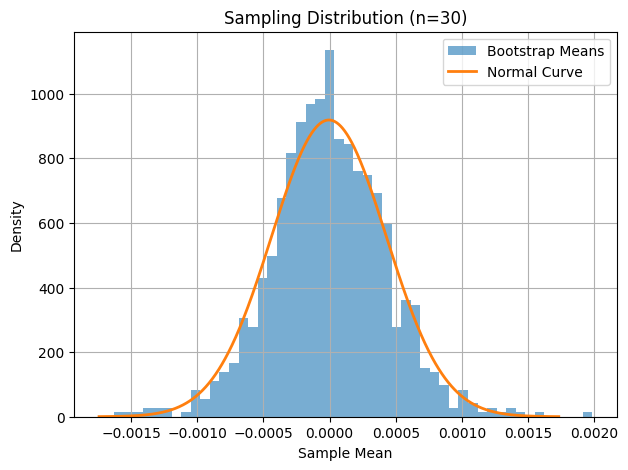

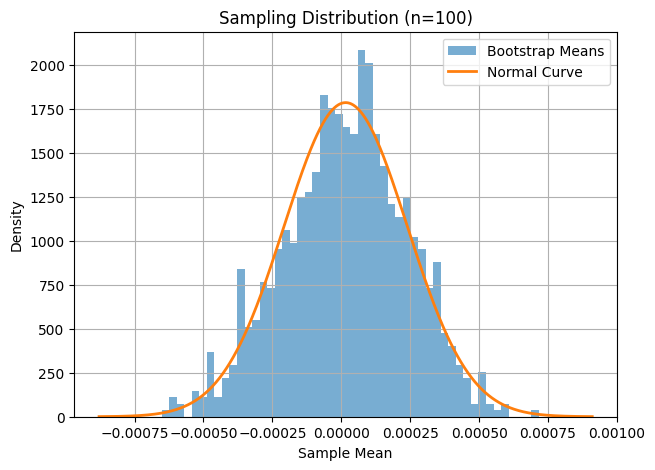

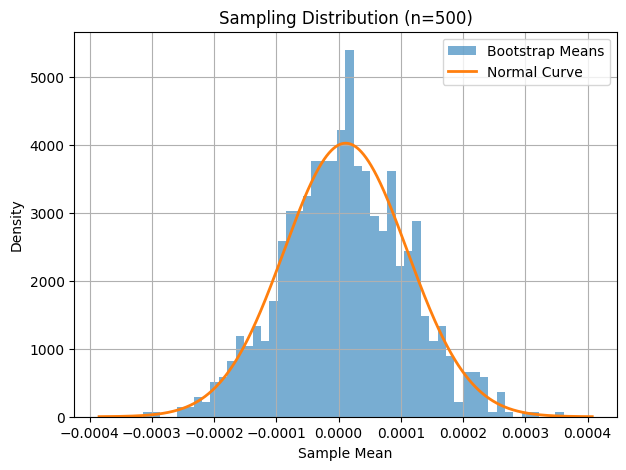

In [31]:
from scipy.stats import norm

def plot_sampling_distribution(sample_sizes, original_data, n_resamples=1000):
    for size in sample_sizes:
        sample_means = [
            np.random.choice(original_data, size=size, replace=True).mean()
            for _ in range(n_resamples)
        ]
        mu = np.mean(sample_means)
        sigma = np.std(sample_means)
        
        # Plot histogram
        plt.figure(figsize=(7, 5))
        plt.hist(sample_means, bins=50, density=True, alpha=0.6, label='Bootstrap Means')
        
        # Overlay normal curve
        x_vals = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
        plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), linewidth=2, label='Normal Curve')
        
        plt.title(f'Sampling Distribution (n={size})')
        plt.xlabel('Sample Mean')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

# Run for increasing sizes
plot_sampling_distribution(
    sample_sizes=[30, 100, 500],
    original_data=x
)

In [32]:
intraday_combined_df.columns

Index(['Date', 'Time', 'Hour', 'Minute', 'Weekday', 'NVDA_Open', 'NVDA_Close',
       'NVDA_open_close_diff', 'NVDA_open_close_diff_pct', 'NVDA_High',
       'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close',
       'NVDA_Volume', 'NVDA_volume_diff_frm_avg',
       'NVDA_volume_diff_frm_avg_pct', 'INOD_Open', 'INOD_Close',
       'INOD_open_close_diff', 'INOD_open_close_diff_pct', 'INOD_High',
       'INOD_Low', 'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close',
       'INOD_Volume', 'INOD_volume_diff_frm_avg',
       'INOD_volume_diff_frm_avg_pct', 'MRVL_Open', 'MRVL_Close',
       'MRVL_open_close_diff', 'MRVL_open_close_diff_pct', 'MRVL_High',
       'MRVL_Low', 'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_Volume', 'MRVL_volume_diff_frm_avg',
       'MRVL_volume_diff_frm_avg_pct', 'INOD_up', 'NVDA_up', 'MRVL_up',
       'NVDA_volume_spike', 'rth_segment', 'interaction_NVDA_return_volume'],
      dtype='object')

Rolling Correlation (Residuals or Raw Returns)

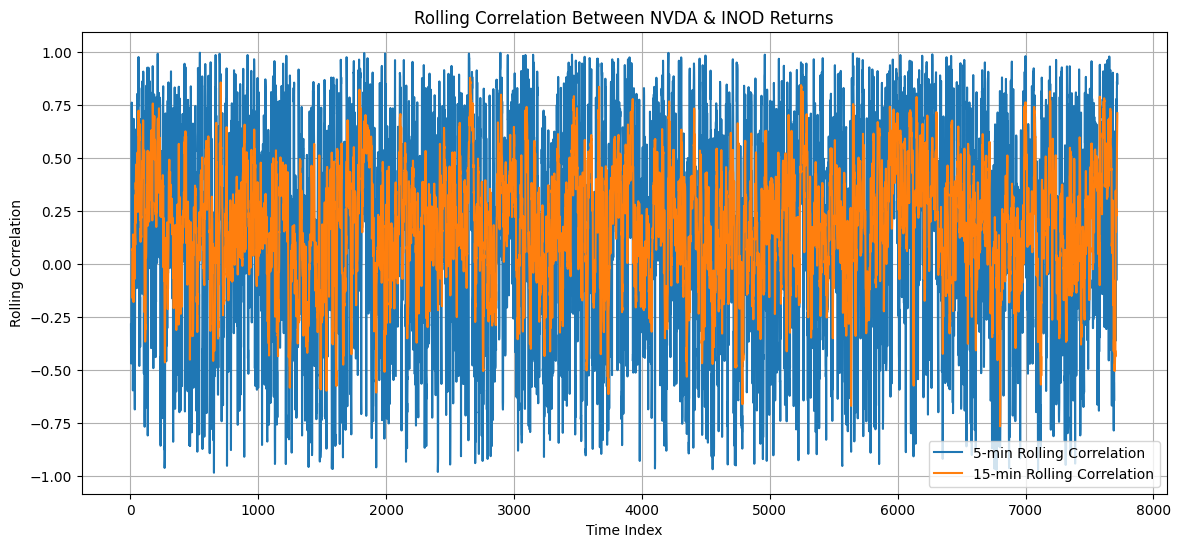

In [33]:
intraday_combined_df['rolling_corr_5min'] = intraday_combined_df['NVDA_open_close_diff_pct'].rolling(window=5).corr(
    intraday_combined_df['INOD_open_close_diff_pct'])

intraday_combined_df['rolling_corr_15min'] = intraday_combined_df['NVDA_open_close_diff_pct'].rolling(window=15).corr(
    intraday_combined_df['INOD_open_close_diff_pct'])

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(intraday_combined_df['rolling_corr_5min'], label='5-min Rolling Correlation')
plt.plot(intraday_combined_df['rolling_corr_15min'], label='15-min Rolling Correlation')
plt.title("Rolling Correlation Between NVDA & INOD Returns")
plt.xlabel("Time Index")
plt.ylabel("Rolling Correlation")
plt.legend()
plt.grid(True)
plt.show()

Granger Causality Test

In [34]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepare the relevant dataframe (drop NaNs, align)
granger_df = intraday_combined_df[[
    'INOD_open_close_diff_pct',
    'NVDA_open_close_diff_pct',
    'NVDA_volume_diff_frm_avg_pct'
]].dropna()

# The Granger causality test expects a 2D array with [y, x]
print("\n=== Granger Causality Test: NVDA Return → INOD Return ===")
grangercausalitytests(granger_df[['INOD_open_close_diff_pct', 'NVDA_open_close_diff_pct']], maxlag=5)

print("\n=== Granger Causality Test: NVDA Volume → INOD Return ===")
grangercausalitytests(granger_df[['INOD_open_close_diff_pct', 'NVDA_volume_diff_frm_avg_pct']], maxlag=5)


=== Granger Causality Test: NVDA Return → INOD Return ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.5650 , p=0.0012  , df_denom=7410, df_num=1
ssr based chi2 test:   chi2=10.5693 , p=0.0011  , df=1
likelihood ratio test: chi2=10.5618 , p=0.0012  , df=1
parameter F test:         F=10.5650 , p=0.0012  , df_denom=7410, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8731  , p=0.0010  , df_denom=7407, df_num=2
ssr based chi2 test:   chi2=13.7555 , p=0.0010  , df=2
likelihood ratio test: chi2=13.7427 , p=0.0010  , df=2
parameter F test:         F=6.8731  , p=0.0010  , df_denom=7407, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9651  , p=0.0078  , df_denom=7404, df_num=3
ssr based chi2 test:   chi2=11.9067 , p=0.0077  , df=3
likelihood ratio test: chi2=11.8971 , p=0.0077  , df=3
parameter F test:         F=3.9651  , p=0.0078  , df_denom=7404, df_num=3

Granger Causality
number of 

{np.int64(1): ({'ssr_ftest': (np.float64(0.35459977857839475),
    np.float64(0.5515389711770473),
    np.float64(7410.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.3547433412417868),
    np.float64(0.5514402433986263),
    np.int64(1)),
   'lrtest': (np.float64(0.35473485352122225),
    np.float64(0.5514450045939066),
    np.int64(1)),
   'params_ftest': (np.float64(0.354599778574781),
    np.float64(0.5515389711788935),
    np.float64(7410.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(38.353135263640105),
    np.float64(2.6859695017159727e-17),
    np.float64(7407.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(76.75805010776305),
    np.float64(2.1488257432733102e-17),
    np.int64(2)),
   'lrtest': (np.float64(76.36332297953777),
    np.float64(2.6176712617365365e-17),
    np.int64(2)),
   'params_ftest': (np.float64(38.353135263640056),
    np.float64(2.6859695017159727e-17),
    np.float64(7407.0),
    2.0)},
   array([[0., 0., 